In [1]:
# ================================
# 0. Imports and global settings
# ================================
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

np.random.seed(42)
torch.manual_seed(42)

pd.set_option("display.max_columns", 120)
pd.set_option("display.float_format", "{:,.4f}".format)


In [2]:
# ================================
# 1. Load Kaggle House Prices data
# ================================
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

train_df.head()


Train shape: (1460, 81)
Test shape : (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,"2,003.0000",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.0000",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.0000",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.0000",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.0000",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


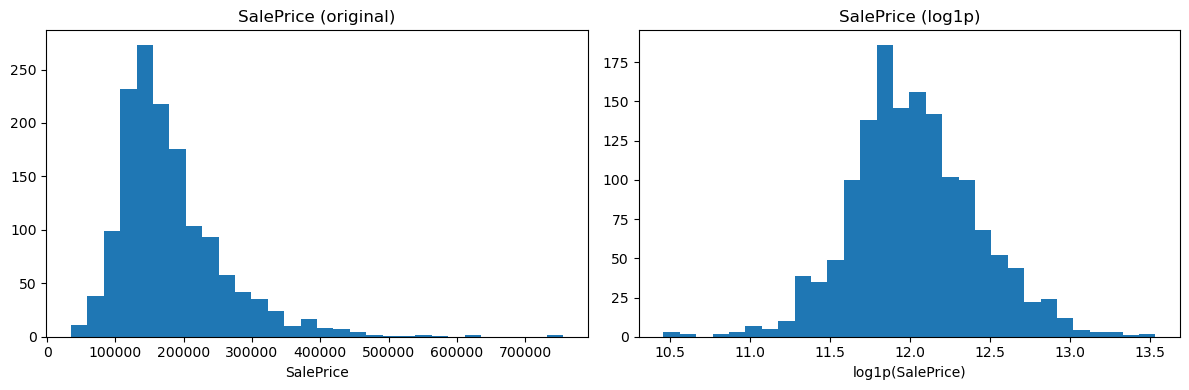

In [3]:
# ================================
# 2. Target: log-transform SalePrice
# ================================
target = "SalePrice"
y = train_df[target]
y_log = np.log1p(y)
X = train_df.drop(columns=[target])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y, bins=30)
axes[0].set_title("SalePrice (original)")
axes[0].set_xlabel("SalePrice")

axes[1].hist(y_log, bins=30)
axes[1].set_title("SalePrice (log1p)")
axes[1].set_xlabel("log1p(SalePrice)")

plt.tight_layout()
plt.show()


In [4]:
# ================================
# 3. Feature types and missing values
# ================================
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))

missing_pct = train_df.isnull().mean().sort_values(ascending=False)
missing_pct[missing_pct > 0].head(20)


Numeric features: 37
Categorical features: 43


PoolQC         0.9952
MiscFeature    0.9630
Alley          0.9377
Fence          0.8075
MasVnrType     0.5973
FireplaceQu    0.4726
LotFrontage    0.1774
GarageYrBlt    0.0555
GarageCond     0.0555
GarageType     0.0555
GarageFinish   0.0555
GarageQual     0.0555
BsmtFinType2   0.0260
BsmtExposure   0.0260
BsmtQual       0.0253
BsmtCond       0.0253
BsmtFinType1   0.0253
MasVnrArea     0.0055
Electrical     0.0007
dtype: float64

In [5]:
# ================================
# 4. Preprocessing: ColumnTransformer
# ================================
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [6]:
# ================================
# 5. Train/validation split
# ================================
X_train, X_val, y_train, y_val = train_test_split(
    X, y_log, test_size=0.2, random_state=42, shuffle=True
)

X_train.shape, X_val.shape


((1168, 80), (292, 80))

In [7]:
# ================================
# 6. Fit preprocessor and transform
# ================================
X_train_trans = preprocessor.fit_transform(X_train)
X_val_trans   = preprocessor.transform(X_val)

print("Transformed shapes:", X_train_trans.shape, X_val_trans.shape)

input_dim = X_train_trans.shape[1]
input_dim


Transformed shapes: (1168, 286) (292, 286)


286

In [8]:
# ================================
# 7. PyTorch Dataset and DataLoader
# ================================
class HousePriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values if isinstance(y, pd.Series) else y,
                              dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64

train_dataset = HousePriceDataset(X_train_trans, y_train)
val_dataset   = HousePriceDataset(X_val_trans, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [9]:
# ================================
# 8. Standard Neural Network model
# ================================
class StandardNN(nn.Module):
    def __init__(self, input_dim):
        super(StandardNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = StandardNN(input_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=10
)


In [10]:
# ================================
# 9. Training loop with early stopping
# ================================
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                n_epochs=200, patience=30):
    history = {
        "train_loss": [],
        "val_loss": []
    }

    best_val_loss = np.inf
    best_state_dict = None
    epochs_no_improve = 0

    for epoch in range(1, n_epochs + 1):
        model.train()
        running_train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * X_batch.size(0)

        train_loss = running_train_loss / len(train_loader.dataset)

        # validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_val_loss += loss.item() * X_batch.size(0)

        val_loss = running_val_loss / len(val_loader.dataset)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        scheduler.step(val_loss)

        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")

        # Early stopping check
        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    return model, history

model, history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    n_epochs=300,
    patience=40
)


Epoch 001 | Train Loss: 145.00827 | Val Loss: 143.76071
Epoch 002 | Train Loss: 130.21730 | Val Loss: 127.49400
Epoch 003 | Train Loss: 117.57426 | Val Loss: 111.52854
Epoch 004 | Train Loss: 105.33909 | Val Loss: 99.32862
Epoch 005 | Train Loss: 92.87037 | Val Loss: 87.51812
Epoch 006 | Train Loss: 79.62992 | Val Loss: 74.23836
Epoch 007 | Train Loss: 66.63731 | Val Loss: 62.01865
Epoch 008 | Train Loss: 53.78678 | Val Loss: 49.52232
Epoch 009 | Train Loss: 41.60746 | Val Loss: 37.67281
Epoch 010 | Train Loss: 31.00497 | Val Loss: 27.84683
Epoch 011 | Train Loss: 22.30142 | Val Loss: 21.25246
Epoch 012 | Train Loss: 15.31970 | Val Loss: 14.45655
Epoch 013 | Train Loss: 10.16277 | Val Loss: 9.79730
Epoch 014 | Train Loss: 6.40970 | Val Loss: 6.43327
Epoch 015 | Train Loss: 4.27577 | Val Loss: 4.80622
Epoch 016 | Train Loss: 2.44860 | Val Loss: 2.40762
Epoch 017 | Train Loss: 1.62104 | Val Loss: 1.56719
Epoch 018 | Train Loss: 1.04551 | Val Loss: 1.19030
Epoch 019 | Train Loss: 0.76110 

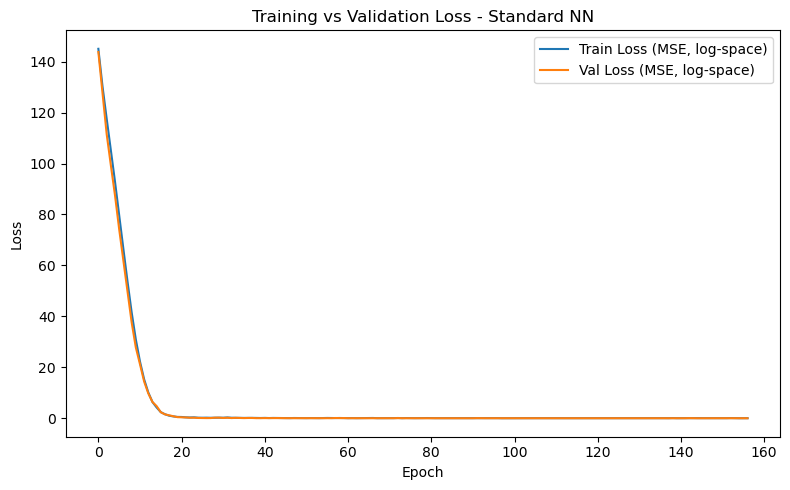

In [11]:
# ================================
# 10. Learning curve
# ================================
plt.figure(figsize=(8,5))
plt.plot(history["train_loss"], label="Train Loss (MSE, log-space)")
plt.plot(history["val_loss"], label="Val Loss (MSE, log-space)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - Standard NN")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
# ================================
# 11. Evaluation: RMSE, MAE, R²
# ================================
model.eval()
with torch.no_grad():
    X_val_tensor = torch.tensor(X_val_trans, dtype=torch.float32).to(device)
    y_val_pred_log_tensor = model(X_val_tensor)
    y_val_pred_log = y_val_pred_log_tensor.cpu().numpy().flatten()

y_val_true = np.expm1(y_val.values)          # back to original SalePrice
y_val_pred = np.expm1(y_val_pred_log)        # back to original SalePrice

mse = mean_squared_error(y_val_true, y_val_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_true, y_val_pred)
r2 = r2_score(y_val_true, y_val_pred)

n = len(y_val_true)
p = X_val_trans.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"MSE   : {mse:,.4f}")
print(f"RMSE  : {rmse:,.4f}")
print(f"MAE   : {mae:,.4f}")
print(f"R²    : {r2:,.4f}")
print(f"Adj R²: {adj_r2:,.4f}")


MSE   : 2,418,131,820.7152
RMSE  : 49,174.5038
MAE   : 30,486.3013
R²    : 0.6847
Adj R²: -17.3480


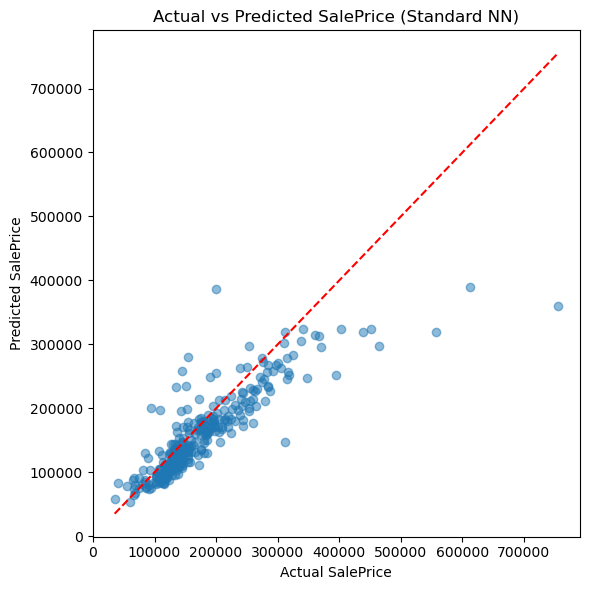

In [13]:
# ================================
# 12. Actual vs Predicted - Standard NN
# ================================
plt.figure(figsize=(6,6))
plt.scatter(y_val_true, y_val_pred, alpha=0.5)
min_val = min(y_val_true.min(), y_val_pred.min())
max_val = max(y_val_true.max(), y_val_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice (Standard NN)")
plt.tight_layout()
plt.show()


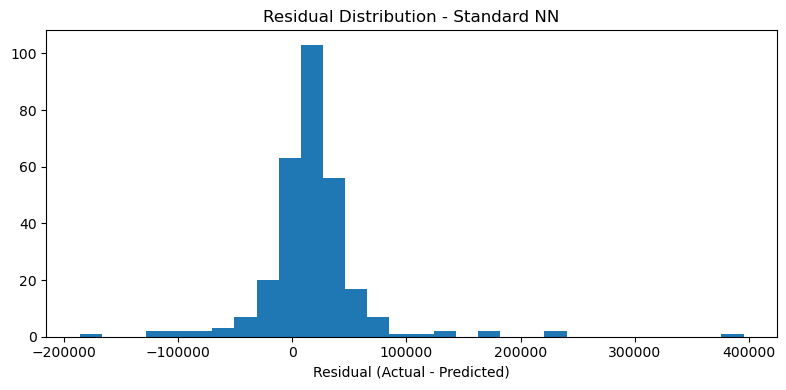

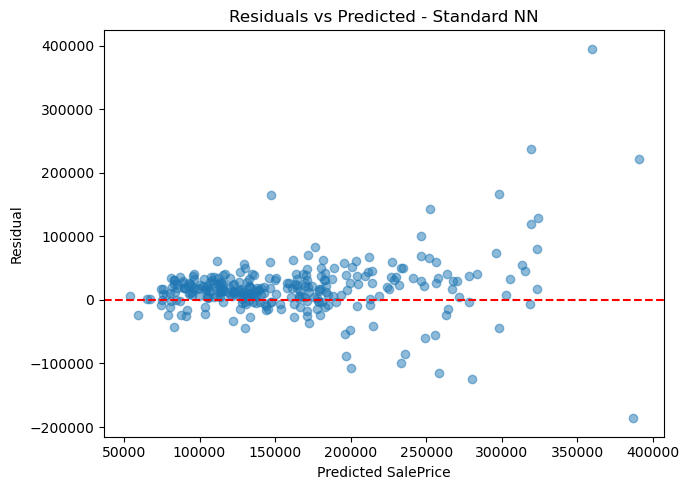

In [14]:
# ================================
# 13. Residual diagnostics
# ================================
residuals = y_val_true - y_val_pred

# Histogram of residuals
plt.figure(figsize=(8,4))
plt.hist(residuals, bins=30, density=False)
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Residual Distribution - Standard NN")
plt.tight_layout()
plt.show()

# Residuals vs Predicted
plt.figure(figsize=(7,5))
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted - Standard NN")
plt.tight_layout()
plt.show()


In [15]:
# ================================
# 14. Final training on FULL data & Final Evaluation
# ================================

# 1) Refit preprocessor on ALL training data
X_full = train_df.drop(columns=[target])
y_full_log = np.log1p(train_df[target])

X_full_trans = preprocessor.fit_transform(X_full)

# Create dataset + loader
full_dataset = HousePriceDataset(X_full_trans, y_full_log)
full_loader  = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

# 2) New NN model for full-data training
final_model = StandardNN(X_full_trans.shape[1]).to(device)
criterion_final = nn.MSELoss()
optimizer_final = torch.optim.Adam(final_model.parameters(), lr=1e-3)

# Scheduler (NO verbose)
scheduler_final = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_final,
    mode="min",
    factor=0.5,
    patience=10
)

# 3) Train NN on full dataset
final_model, history_full = train_model(
    final_model,
    full_loader,
    full_loader,   # reused for scheduler only
    criterion_final,
    optimizer_final,
    scheduler_final,
    n_epochs=200,
    patience=40
)






Epoch 001 | Train Loss: 131.80892 | Val Loss: 132.73485
Epoch 002 | Train Loss: 114.37014 | Val Loss: 104.11822
Epoch 003 | Train Loss: 96.75125 | Val Loss: 83.39828
Epoch 004 | Train Loss: 79.20430 | Val Loss: 71.40829
Epoch 005 | Train Loss: 62.61476 | Val Loss: 56.29355
Epoch 006 | Train Loss: 47.80364 | Val Loss: 42.41494
Epoch 007 | Train Loss: 35.01888 | Val Loss: 30.72360
Epoch 008 | Train Loss: 24.21452 | Val Loss: 21.02108
Epoch 009 | Train Loss: 16.05228 | Val Loss: 13.27999
Epoch 010 | Train Loss: 9.91923 | Val Loss: 8.34632
Epoch 011 | Train Loss: 5.87502 | Val Loss: 5.13273
Epoch 012 | Train Loss: 3.48043 | Val Loss: 2.73582
Epoch 013 | Train Loss: 1.89227 | Val Loss: 1.36535
Epoch 014 | Train Loss: 1.25279 | Val Loss: 0.63816
Epoch 015 | Train Loss: 0.86380 | Val Loss: 0.56487
Epoch 016 | Train Loss: 0.52558 | Val Loss: 0.26827
Epoch 017 | Train Loss: 0.48402 | Val Loss: 0.24748
Epoch 018 | Train Loss: 0.62891 | Val Loss: 0.28504
Epoch 019 | Train Loss: 0.49818 | Val Loss

In [16]:
# ================================
# 15. Final Performance Evaluation (using FULL preprocessor)
# ================================

# IMPORTANT: Re-transform validation using full-data preprocessor
X_val_trans_full = preprocessor.transform(X_val)

final_model.eval()
with torch.no_grad():
    X_val_tensor = torch.tensor(X_val_trans_full, dtype=torch.float32).to(device)
    y_val_pred_log_tensor = final_model(X_val_tensor)
    y_val_pred_log = y_val_pred_log_tensor.cpu().numpy().flatten()

# Convert to real SalePrice
y_val_true = np.expm1(y_val.values)
y_val_pred = np.expm1(y_val_pred_log)

# Metrics
mse  = mean_squared_error(y_val_true, y_val_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_val_true, y_val_pred)
r2   = r2_score(y_val_true, y_val_pred)

n = len(y_val_true)
p = X_val_trans_full.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("===============================================")
print(" FINAL NN PERFORMANCE (ON VALIDATION SET) ")
print("===============================================")
print(f"MSE   : {mse:,.4f}")
print(f"RMSE  : {rmse:,.4f}")
print(f"MAE   : {mae:,.4f}")
print(f"R²    : {r2:,.4f}")
print(f"Adj R²: {adj_r2:,.4f}")


 FINAL NN PERFORMANCE (ON VALIDATION SET) 
MSE   : 1,297,576,687.4903
RMSE  : 36,021.8918
MAE   : 22,873.2162
R²    : 0.8308
Adj R²: -15.4093


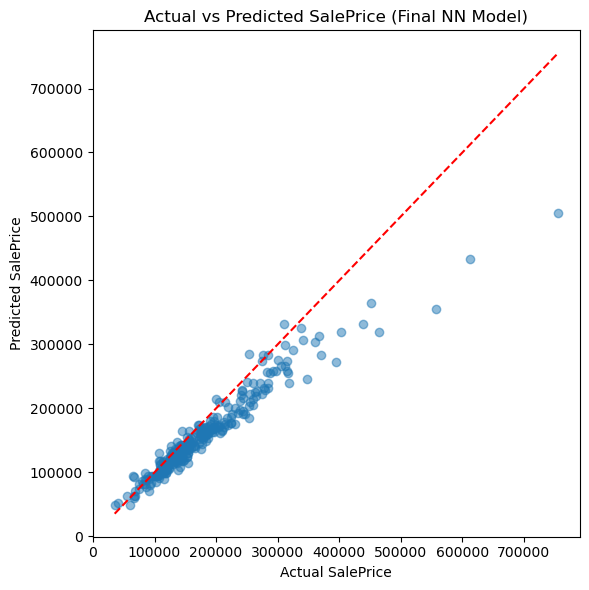

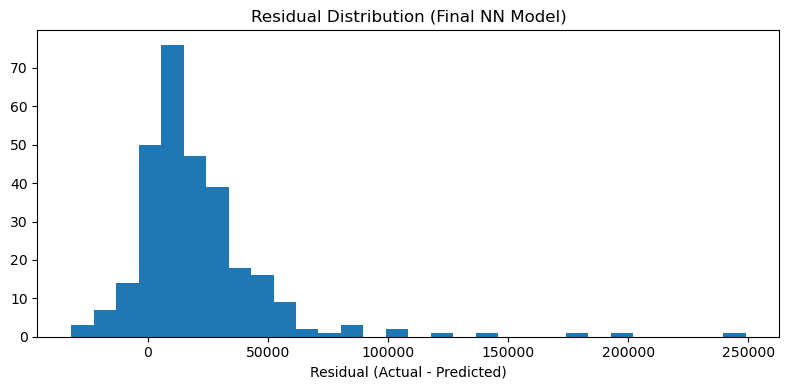

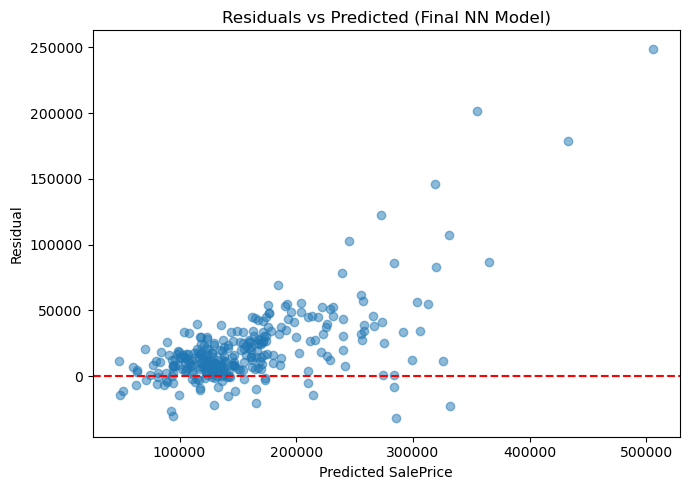

In [17]:
# ================================
# 16. PLOTS FOR FINAL MODEL
# ================================

# ---- Actual vs Predicted ----
plt.figure(figsize=(6,6))
plt.scatter(y_val_true, y_val_pred, alpha=0.5)
min_val = min(y_val_true.min(), y_val_pred.min())
max_val = max(y_val_true.max(), y_val_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice (Final NN Model)")
plt.tight_layout()
plt.show()

# ---- Residual Distribution ----
residuals = y_val_true - y_val_pred

plt.figure(figsize=(8,4))
plt.hist(residuals, bins=30)
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Residual Distribution (Final NN Model)")
plt.tight_layout()
plt.show()

# ---- Residuals vs Predicted ----
plt.figure(figsize=(7,5))
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted (Final NN Model)")
plt.tight_layout()
plt.show()

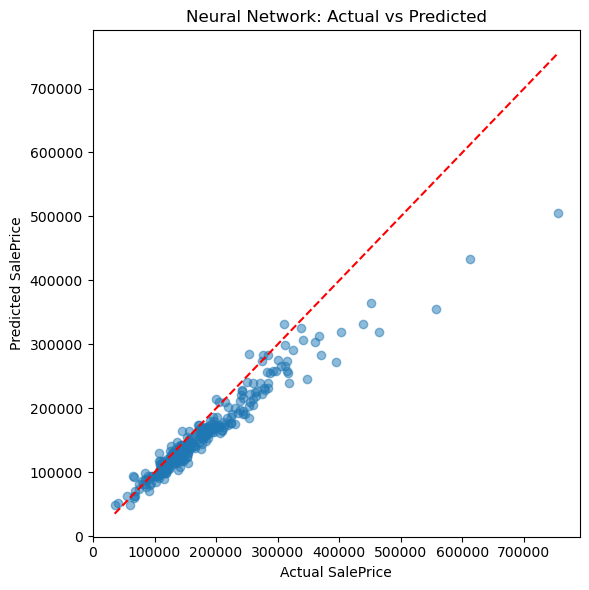

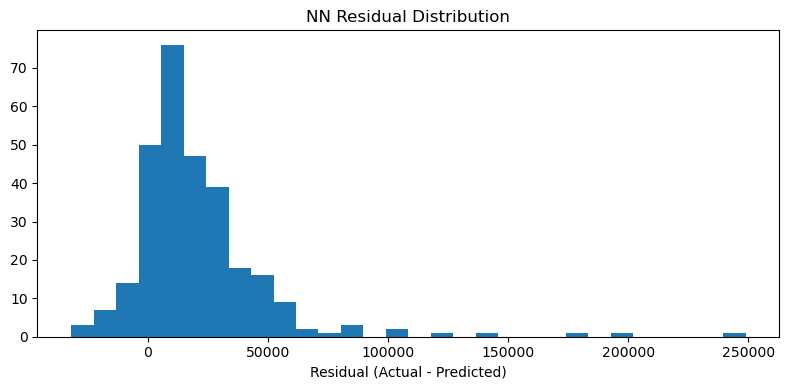

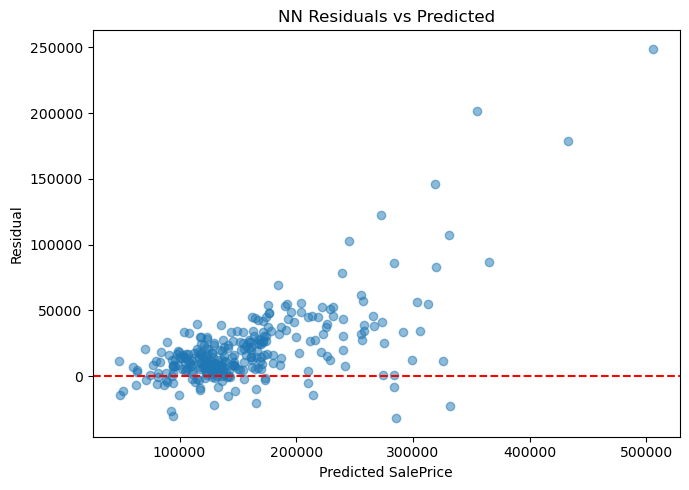

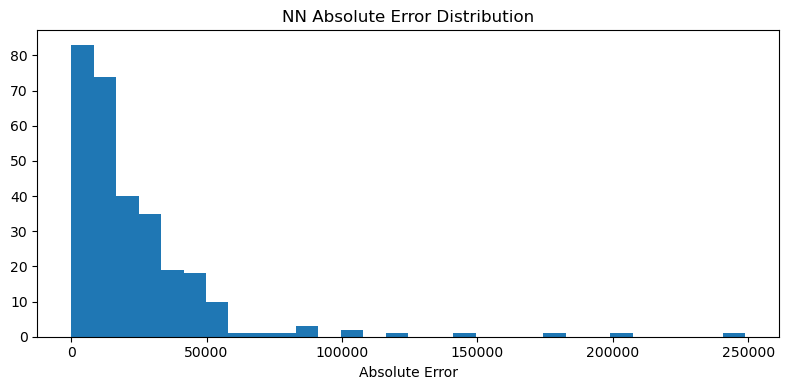

In [18]:
# ============================================
# PLOT 1 — ACTUAL vs PREDICTED
# ============================================
plt.figure(figsize=(6,6))
plt.scatter(y_val_true, y_val_pred, alpha=0.5)
min_val = min(y_val_true.min(), y_val_pred.min())
max_val = max(y_val_true.max(), y_val_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Neural Network: Actual vs Predicted")
plt.tight_layout()
plt.show()


# ============================================
# PLOT 2 — RESIDUAL DISTRIBUTION
# ============================================
residuals = y_val_true - y_val_pred

plt.figure(figsize=(8,4))
plt.hist(residuals, bins=30)
plt.xlabel("Residual (Actual - Predicted)")
plt.title("NN Residual Distribution")
plt.tight_layout()
plt.show()


# ============================================
# PLOT 3 — RESIDUALS vs PREDICTED
# ============================================
plt.figure(figsize=(7,5))
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residual")
plt.title("NN Residuals vs Predicted")
plt.tight_layout()
plt.show()


# ============================================
# PLOT 4 — ABSOLUTE ERROR HISTOGRAM
# ============================================
abs_error = np.abs(residuals)

plt.figure(figsize=(8,4))
plt.hist(abs_error, bins=30)
plt.xlabel("Absolute Error")
plt.title("NN Absolute Error Distribution")
plt.tight_layout()
plt.show()


In [19]:
# ============================================
# FINAL NEURAL NETWORK PERFORMANCE
# ============================================

# Re-transform validation set
X_val_trans_full = preprocessor.transform(X_val)

# Predict (log space)
final_model.eval()
with torch.no_grad():
    X_val_tensor = torch.tensor(X_val_trans_full, dtype=torch.float32).to(device)
    y_val_pred_log_nn_tensor = final_model(X_val_tensor)
    y_val_pred_log_nn = y_val_pred_log_nn_tensor.cpu().numpy().flatten()

# Back-transform
y_val_true_nn = np.expm1(y_val.values)
y_val_pred_nn = np.expm1(y_val_pred_log_nn)

# Metrics
mse_nn  = mean_squared_error(y_val_true_nn, y_val_pred_nn)
rmse_nn = np.sqrt(mse_nn)
mae_nn  = mean_absolute_error(y_val_true_nn, y_val_pred_nn)
r2_nn   = r2_score(y_val_true_nn, y_val_pred_nn)

print("===================================")
print(" FINAL NEURAL NETWORK PERFORMANCE ")
print("===================================")
print(f"MSE  : {mse_nn:,.4f}")
print(f"RMSE : {rmse_nn:,.4f}")
print(f"MAE  : {mae_nn:,.4f}")
print(f"R²   : {r2_nn:,.4f}")


 FINAL NEURAL NETWORK PERFORMANCE 
MSE  : 1,297,576,687.4903
RMSE : 36,021.8918
MAE  : 22,873.2162
R²   : 0.8308
